Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


최적의 매개변수:
{'n_estimators': 733, 'min_samples_split': 38, 'min_samples_leaf': 73, 'max_leaf_nodes': 1046, 'max_features': 282, 'max_depth': 934}

엑스트라트리 내부 정확도: 0.5750
[[ 0 17  0  0]
 [ 0 46  0  0]
 [ 0  8  0  0]
 [ 0  9  0  0]]
엑스트라트리 외부 정확도: 0.5714
[[ 0  4  0  0]
 [ 0 12  0  0]
 [ 0  2  0  0]
 [ 0  3  0  0]]
엑스트라트리 전체 정확도: 0.5743
[[ 0 21  0  0]
 [ 0 58  0  0]
 [ 0 10  0  0]
 [ 0 12  0  0]]
엑스트라트리 Others 정확도: 0.0000
[[ 0 42  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


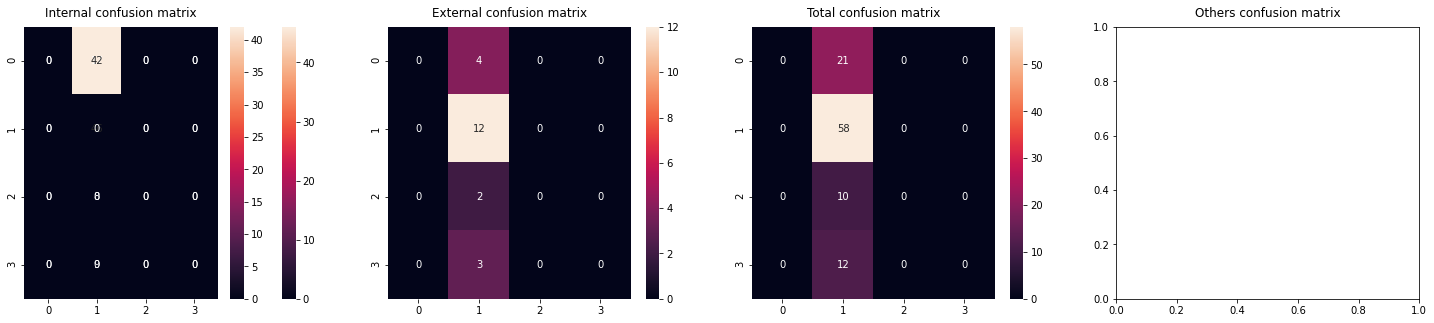

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from google.colab import drive
drive.mount('/content/drive')

seed=0
np.random.seed(seed)

#데이터 입력
df = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/rdkit_fingerprint/PA_rdkitfingerprint_apppendscore_dropsmiles.csv')
data = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/rdkit_fingerprint/PAOthers_rdkitfingerprint_apppendscore_dropsmiles.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

data = data.values
X_others =data[:,0:-1]
Y_others =data[:,-1]

#X 표준화

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_others_scaled = scaler.transform(X_others)
#totX_scaled = scaler.fit_transform(totX)

#Oversampling using SMOTE

smote = SMOTE(random_state=seed)
X_over, Y_over = smote.fit_sample(X, Y)

#데이터 split

train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.2, random_state=seed)

params={'n_estimators':list(range(10,1000)), 'max_depth':list(range(2,2000)),'min_samples_split': list(range(2,100)), 'min_samples_leaf': list(range(1,100)), 'max_features': list(range(2,2000)),'max_leaf_nodes': list(range(1,2000))}
et = ExtraTreesClassifier(random_state=seed, n_jobs=-1)
et_search = RandomizedSearchCV(et, params, n_iter=100, n_jobs=-1, cv=5, scoring='accuracy', random_state=seed)
scores = cross_validate(et_search, train_input, train_target, return_train_score=True, n_jobs=-1)
#print(et_search.best_estimator_) #요 파라미터는 fit 시킨 후에 해야 적용
#print(np.mean(scores['train_score']), np.mean(scores['test_score']))

et_search.fit(train_input, train_target)

print("최적의 매개변수:\n{}\n".format(et_search.best_params_))
#print("최상의 교차 검증 점수:{:.2f}".format(np.max(grid.cv_results_['mean_test_score'])))

#scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
#print(np.mean(scores['train_score']), np.mean(scores['test_score']))

et_results = pd.DataFrame(et_search.cv_results_)
et_results.to_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/ExtraTree_cv_results(0406).csv',index=False) 
et_best = et_search.best_estimator_

#confusion matrix 구하기

pred = et_best.predict(train_input)
accuracy = accuracy_score(train_target, pred)
print('엑스트라트리 내부 정확도: {0:.4f}'.format(accuracy))
conf_matrix = confusion_matrix(train_target, pred, labels=[0,1,2,3])
print(conf_matrix)

pred2 = et_best.predict(test_input)
accuracy = accuracy_score(test_target, pred2)
print('엑스트라트리 외부 정확도: {0:.4f}'.format(accuracy))
conf_matrix2 = confusion_matrix(test_target, pred2, labels=[0,1,2,3])
print(conf_matrix2)

pred3 = et_best.predict(X_scaled)
accuracy = accuracy_score(Y, pred3)
print('엑스트라트리 전체 정확도: {0:.4f}'.format(accuracy))
conf_matrix3 = confusion_matrix(Y, pred3, labels=[0,1,2,3])
print(conf_matrix3)

pred4 = et_best.predict(X_others_scaled)
accuracy = accuracy_score(Y_others, pred4)
print('엑스트라트리 Others 정확도: {0:.4f}'.format(accuracy))
conf_matrix4 = confusion_matrix(Y_others, pred4, labels=[0,1,2,3])
print(conf_matrix4)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 5))
sns.heatmap(conf_matrix, annot=True, ax=ax[0])
ax[0].set_title('Internal confusion matrix', pad = 10)
sns.heatmap(conf_matrix2, annot=True, ax=ax[1])
ax[1].set_title('External confusion matrix', pad = 10)
sns.heatmap(conf_matrix3, annot=True, ax=ax[2])
ax[2].set_title('Total confusion matrix', pad = 10)
sns.heatmap(conf_matrix4, annot=True, ax=ax[3])
ax[3].set_title('Others confusion matrix', pad = 10)


#모델 저장
saved_model = joblib.dump(et_best,'/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/PA_ExtraTree_0406_01.pkl')